In [6]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Scrape Books to Scrape (First source)
def scrape_books_to_scrape(max_books=150):
    books = []
    url = 'https://books.toscrape.com/catalogue/page-1.html'
    base_url = 'https://books.toscrape.com/catalogue/'
    while url and len(books) < max_books:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        articles = soup.find_all('article', class_='product_pod')
        for article in articles:
            if len(books) >= max_books:
                break
            title = article.h3.a['title']
            price = article.find('p', class_='price_color').text.strip()
            rating_class = article.find('p', class_='star-rating')['class'][1]
            availability = article.find('p', class_='instock availability').text.strip()
            # الدخول على صفحة الكتاب عشان نجيب الكاتيجوري
            detail_url = base_url + article.h3.a['href'].replace('../../../', '')
            detail_response = requests.get(detail_url)
            detail_soup = BeautifulSoup(detail_response.content, 'html.parser')
            category = detail_soup.find('ul', class_='breadcrumb').find_all('li')[2].text.strip()
            books.append({
                'title': title,
                'price': price,
                'rating': rating_class,
                'availability': availability,
                'category': category,
                'source': 'Books to Scrape'
            })
        next_button = soup.find('li', class_='next')
        if next_button:
            url = 'https://books.toscrape.com/catalogue/' + next_button.a['href']
        else:
            url = None
    return books

In [7]:
# Scrape OpenLibrary (Second source)
def scrape_openlibrary(max_books=150):
    books = []
    base_url = "https://openlibrary.org/search.json?q=python"
    response = requests.get(base_url)
    if response.status_code == 200:
        data = response.json()
        docs = data.get('docs', [])
        for doc in docs[:max_books]:
            title = doc.get('title', 'Unknown')
            price = f"£{random.randint(10, 100)}.00"  # Fake price
            rating = random.choice(['One', 'Two', 'Three', 'Four', 'Five'])
            availability = 'In stock'
            subjects = doc.get('subject')
            if subjects:
                category = subjects[0]
            else:
                category = 'Programming'
            books.append({
                'title': title,
                'price': price,
                'rating': rating,
                'availability': availability,
                'category': category,
                'source': 'OpenLibrary'
            })
    return books

In [8]:
# Scrape Google Books API (Third source)
def scrape_google_books_api(max_books=150):
    books = []
    base_url = "https://www.googleapis.com/books/v1/volumes?q=python&maxResults=40"  # Search query and max results
    response = requests.get(base_url)
    
    if response.status_code == 200:
        data = response.json()
        items = data.get('items', [])
        for item in items[:max_books]:
            title = item['volumeInfo'].get('title', 'Unknown')
            price = 'N/A'  # Google Books API does not provide price
            rating = item['volumeInfo'].get('averageRating', 'N/A')
            availability = 'In stock'  # Not available in Google Books API, so we assume it's in stock
            categories = item['volumeInfo'].get('categories', ['N/A'])
            category = ', '.join(categories)
            books.append({
                'title': title,
                'price': price,
                'rating': rating,
                'availability': availability,
                'category': category,
                'source': 'Google Books API'
            })
    return books

In [9]:
# Clean price function
def clean_price(price):
    return price.replace('Â', '').replace('Ã‚', '').replace('Â£', '£').strip()

# Get books from all sources
books1 = scrape_books_to_scrape(max_books=150)
books2 = scrape_openlibrary(max_books=150)
books3 = scrape_google_books_api(max_books=150)

# Combine all books
all_books = books1 + books2 + books3

# Clean prices
for book in all_books:
    book['price'] = clean_price(book['price'])

# Save to CSV
df = pd.DataFrame(all_books)
df.to_csv(r"C:\Users\yasse\Downloads\books.csv", index=False, encoding='utf-8-sig')

# Read the saved file
df = pd.read_csv(r"C:\Users\yasse\Downloads\books.csv")
df.head(10)


,title,price,rating,availability,category,source
0,A Light in the Attic,£51.77,Three,In stock,Poetry,Books to Scrape
1,Tipping the Velvet,£53.74,One,In stock,Historical Fiction,Books to Scrape
2,Soumission,£50.10,One,In stock,Fiction,Books to Scrape
3,Sharp Objects,£47.82,Four,In stock,Mystery,Books to Scrape
4,Sapiens: A Brief History of Humankind,£54.23,Five,In stock,History,Books to Scrape
5,The Requiem Red,£22.65,One,In stock,Young Adult,Books to Scrape
6,The Dirty Little Secrets of Getting Your Dream...,£33.34,Four,In stock,Business,Books to Scrape
7,The Coming Woman: A Novel Based on the Life of...,£17.93,Three,In stock,Default,Books to Scrape
8,The Boys in the Boat: Nine Americans and Their...,£22.60,Four,In stock,Default,Books to Scrape
9,The Black Maria,£52.15,One,In stock,Poetry,Books to Scrape


In [10]:
print(df.columns)

Index(['title', 'price', 'rating', 'availability', 'category', 'source'], dtype='object')


In [11]:
print(df.isnull().sum())

title            0
price           40
rating          33
availability     0
category         1
source           0
dtype: int64


In [12]:
df.dropna(inplace=True)
print(df.isnull().sum())

title           0
price           0
rating          0
availability    0
category        0
source          0
dtype: int64


In [13]:
df['category'] = df['category'].apply(lambda x: x if isinstance(x, str) else 'Unknown')


In [14]:
# Descriptive Analysis Section
# =============================================

# Clean and prepare numerical data
df['price'] = df['price'].str.replace('£', '').str.replace(',', '').astype(float)

# Convert ratings to numerical values
rating_map = {'One': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5}
df['rating_num'] = df['rating'].map(rating_map)


In [15]:
# 1. Basic Descriptive Statistics
# =============================================
print("\n=== BASIC DESCRIPTIVE STATISTICS ===\n")
print("Dataset shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nDescriptive statistics for numerical columns:\n", df[['price', 'rating_num']].describe())


=== BASIC DESCRIPTIVE STATISTICS ===

Dataset shape: (250, 7)

Data types:
 title            object
price           float64
rating           object
availability     object
category         object
source           object
rating_num        int64
dtype: object

Descriptive statistics for numerical columns:
             price  rating_num
count  250.000000  250.000000
mean    42.766440    2.896000
std     21.958568    1.413214
min     10.000000    1.000000
25%     24.030000    2.000000
50%     39.125000    3.000000
75%     55.882500    4.000000
max     99.000000    5.000000


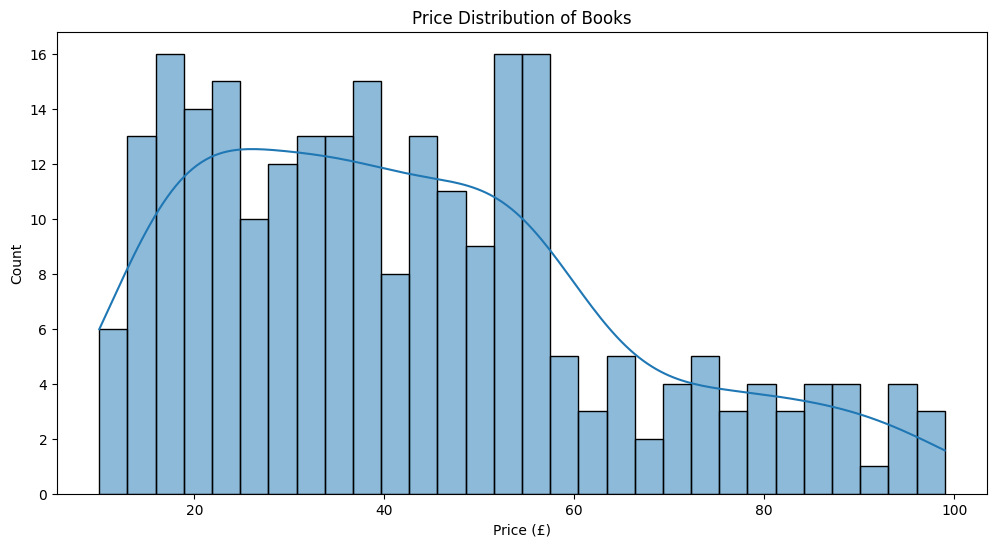

In [16]:
# 2. Price Analysis
# =============================================
plt.figure(figsize=(12, 6))
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Price Distribution of Books')
plt.xlabel('Price (£)')
plt.ylabel('Count')
plt.show()

In [17]:
print("\n=== PRICE ANALYSIS ===")
print(f"Mean price: £{df['price'].mean():.2f}")
print(f"Median price: £{df['price'].median():.2f}")
print(f"Minimum price: £{df['price'].min():.2f}")
print(f"Maximum price: £{df['price'].max():.2f}")
print(f"Standard deviation: £{df['price'].std():.2f}")


=== PRICE ANALYSIS ===
Mean price: £42.77
Median price: £39.12
Minimum price: £10.00
Maximum price: £99.00
Standard deviation: £21.96


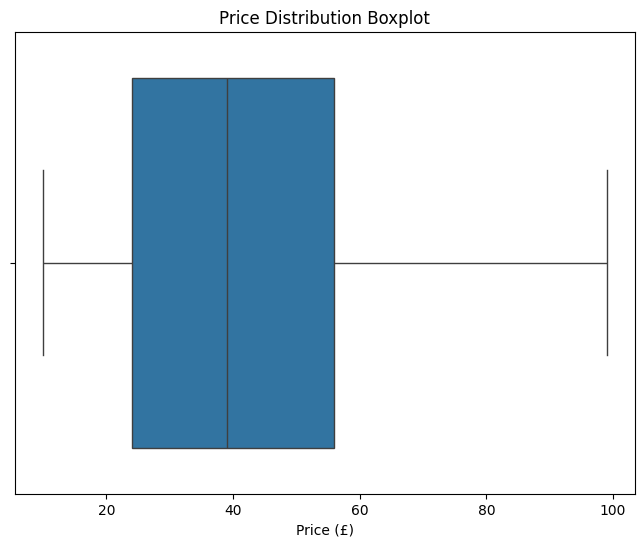

In [18]:
# Boxplot for price distribution
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['price'])
plt.title('Price Distribution Boxplot')
plt.xlabel('Price (£)')
plt.show()

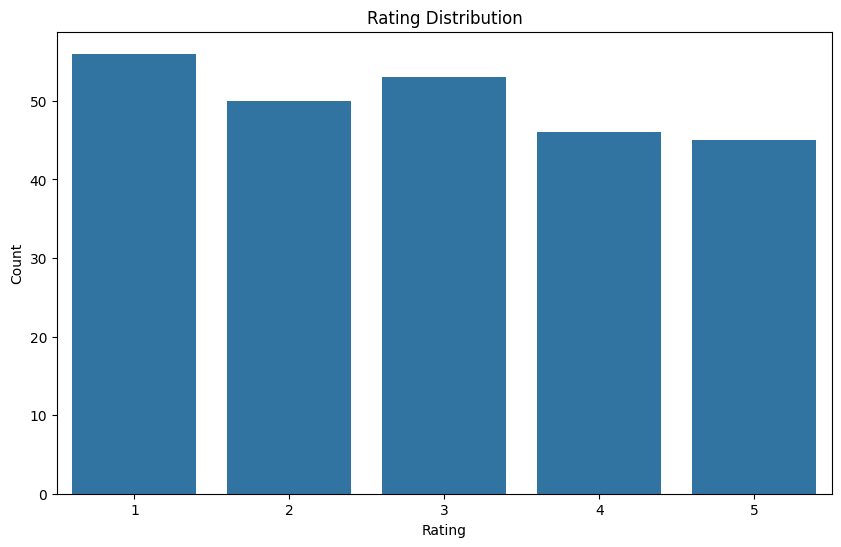


=== RATING ANALYSIS ===
Rating counts:
 rating_num
1    56
2    50
3    53
4    46
5    45
Name: count, dtype: int64


In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating_num', data=df)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

print("\n=== RATING ANALYSIS ===")
print("Rating counts:\n", df['rating_num'].value_counts().sort_index())

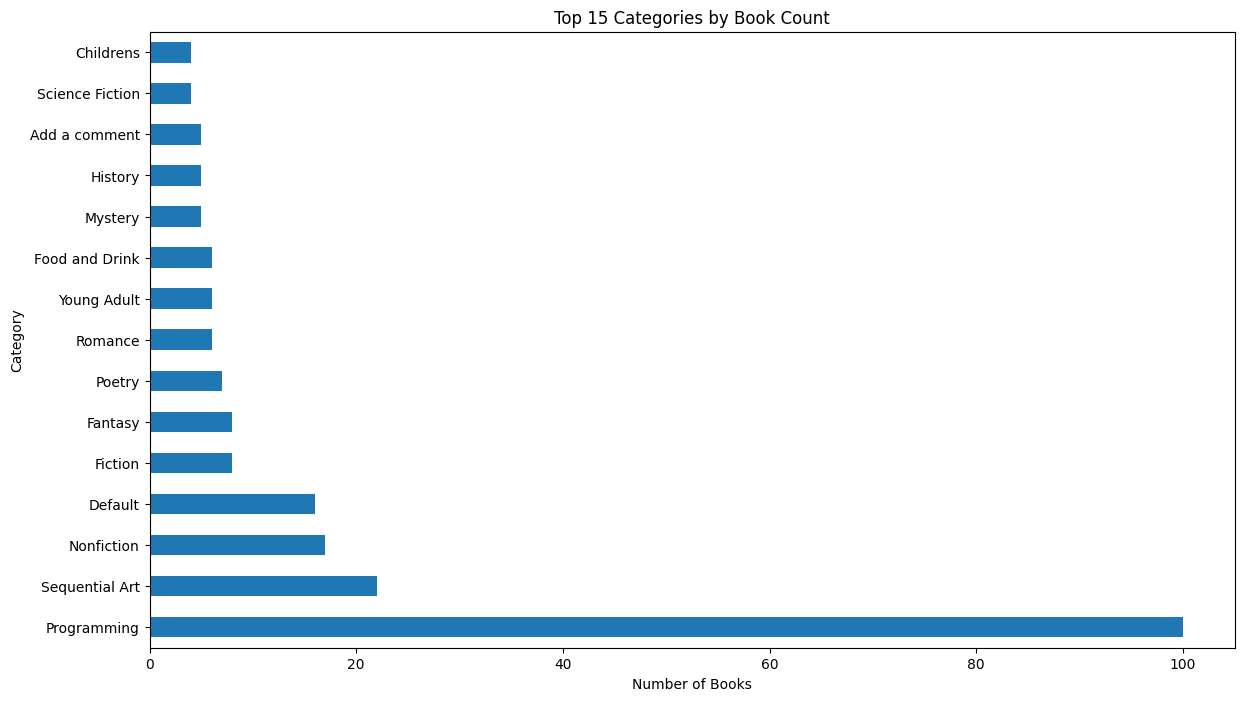

In [20]:
# 4. Category Analysis
# =============================================
# Top categories by count
plt.figure(figsize=(14, 8))
df['category'].value_counts().head(15).plot(kind='barh')
plt.title('Top 15 Categories by Book Count')
plt.xlabel('Number of Books')
plt.ylabel('Category')
plt.show()

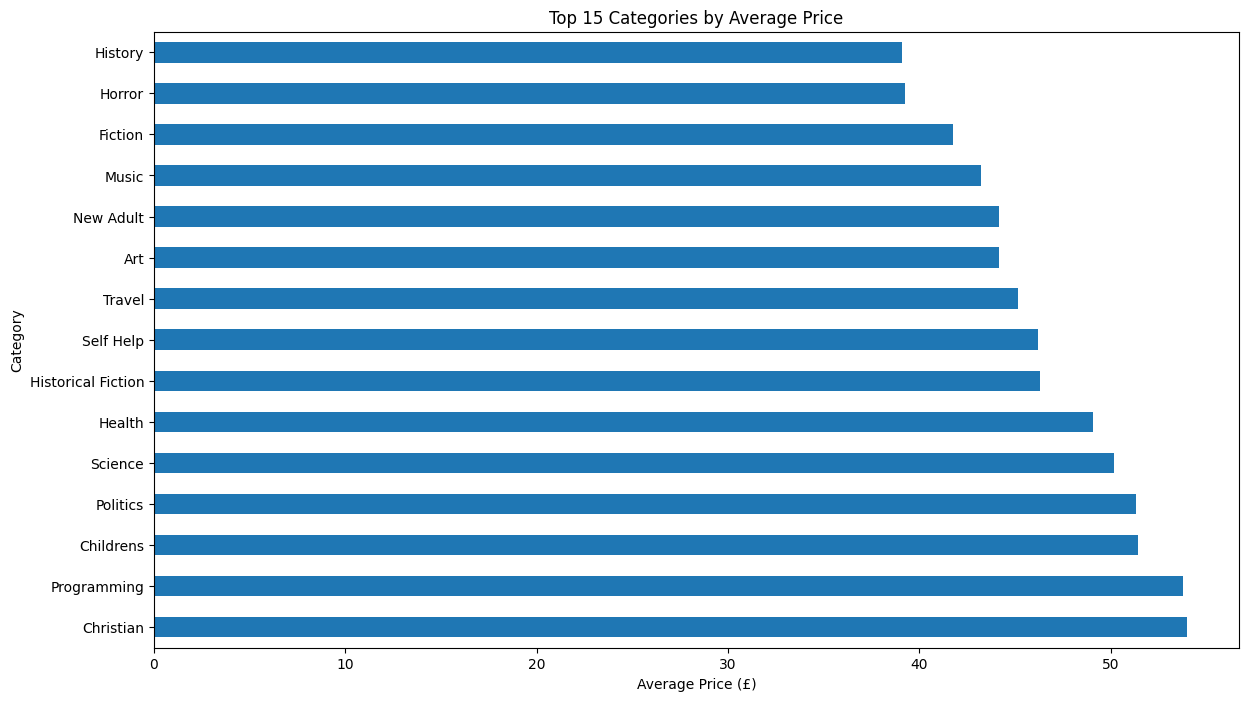

In [21]:
# Average price by category (top 15)
plt.figure(figsize=(14, 8))
df.groupby('category')['price'].mean().sort_values(ascending=False).head(15).plot(kind='barh')
plt.title('Top 15 Categories by Average Price')
plt.xlabel('Average Price (£)')
plt.ylabel('Category')
plt.show()


=== SOURCE ANALYSIS ===
Books by source:
 source
Books to Scrape    150
OpenLibrary        100
Name: count, dtype: int64


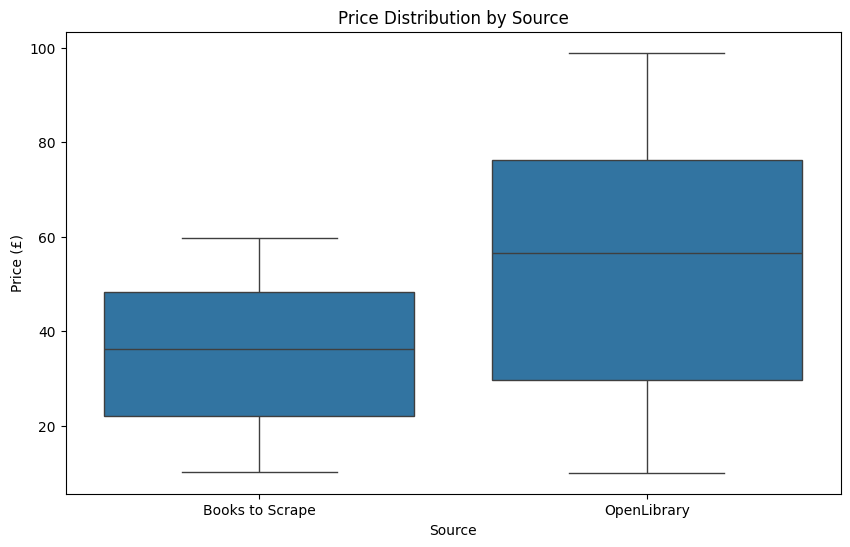

In [22]:
# 5. Source Analysis
# =============================================
print("\n=== SOURCE ANALYSIS ===")
print("Books by source:\n", df['source'].value_counts())

# Price distribution by source
plt.figure(figsize=(10, 6))
sns.boxplot(x='source', y='price', data=df)
plt.title('Price Distribution by Source')
plt.xlabel('Source')
plt.ylabel('Price (£)')
plt.show()

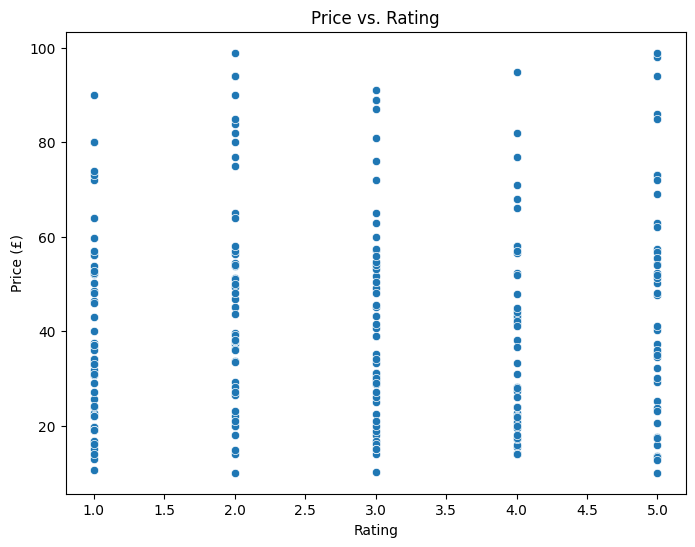


Correlation between price and rating:
                price  rating_num
price       1.000000    0.027495
rating_num  0.027495    1.000000


In [23]:
# 6. Correlation Analysis
# =============================================
# Scatter plot of price vs rating
plt.figure(figsize=(8, 6))
sns.scatterplot(x='rating_num', y='price', data=df)
plt.title('Price vs. Rating')
plt.xlabel('Rating')
plt.ylabel('Price (£)')
plt.show()

# Correlation matrix
corr = df[['price', 'rating_num']].corr()
print("\nCorrelation between price and rating:\n", corr)


In [24]:
# 7. Outlier Detection
# =============================================
# Detect price outliers using IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print(f"\nNumber of price outliers: {len(outliers)}")

# Display top 10 most expensive books
print("\nTop 10 Most Expensive Books:")
print(outliers.nlargest(10, 'price')[['title', 'price', 'category', 'source']])


Number of price outliers: 0

Top 10 Most Expensive Books:
Empty DataFrame
Columns: [title, price, category, source]
Index: []


In [25]:
# 8. Availability Analysis
# =============================================
print("\n=== AVAILABILITY ANALYSIS ===")
print("Availability counts:\n", df['availability'].value_counts())

# =============================================
# 9. Save Analysis Results
# =============================================
# Save cleaned data with numerical ratings
df.to_csv('books_data_cleaned.csv', index=False)

print("\n=== ANALYSIS COMPLETED ===")


=== AVAILABILITY ANALYSIS ===
Availability counts:
 availability
In stock    250
Name: count, dtype: int64

=== ANALYSIS COMPLETED ===


In [31]:
print(df.columns)

Index(['title', 'price', 'rating', 'availability', 'category', 'source',
       'rating_num'],
      dtype='object')


In [32]:
from sqlalchemy import create_engine
import urllib

# إعداد الاتصال
params = urllib.parse.quote_plus(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=ALNAFRAWI;"
    "DATABASE=BooksDB;"
    "Trusted_Connection=yes;"
)

# إنشاء محرك SQLAlchemy
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

# حفظ البيانات في جدول اسمه books
df.to_sql('books', con=engine, if_exists='append', index=False)



250